In [ ]:
pip install numpy pandas scikit-learn opencv-python opencv-python-headless matplotlib 

  Using cached pandas-2.0.3-cp38-cp38-win_amd64.whl.metadata (18 kB)
  Using cached scikit_learn-1.3.2-cp38-cp38-win_amd64.whl.metadata (11 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached matplotlib-3.7.5-cp38-cp38-win_amd64.whl.metadata (5.8 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.10.1-cp38-cp38-win_amd64.whl.metadata (58 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.1.1-cp38-cp38-win_amd64.whl.metadata (5.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.55.3-cp38-cp38-win_amd64.whl.metadata (168 kB)
  Using cached kiwisolver-1.4.7-cp38-cp38-win_amd64.whl.metadata (6.

In [13]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3060 Laptop GPU
Using device: cuda


In [8]:
import os
import random
import csv

def collect_images_recursively(base_folder):
    """
    Recursively collect image paths from all subdirectories.
    """
    image_paths = []
    for root, _, files in os.walk(base_folder):
        for file in sorted(files):
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Add more formats if needed
                image_paths.append(os.path.join(root, file))
    return image_paths

def prepare_dataset(real_faces_folder, real_flow_folder, fake_faces_folder, fake_flow_folder, output_csv):
    """
    Prepare a CSV dataset mapping spatial frames (cropped faces) and optical flow images with labels
    for real and fake data.
    """
    dataset = []

    def process_real_data(cropped_faces_folder, optical_flow_folder, label):
        """
        Process real data, filtering only subdirectories containing "uniform" and "camera_front".
        """
        print("[INFO] Processing real data...")
        for subdir_name in sorted(os.listdir(cropped_faces_folder)):
            if "uniform" not in subdir_name or "camera_front" not in subdir_name:
                continue

            subdir_path = os.path.join(cropped_faces_folder, subdir_name)
            flow_path = os.path.join(optical_flow_folder, subdir_name)

            if not os.path.isdir(subdir_path) or not os.path.isdir(flow_path):
                continue

            spatial_frames = collect_images_recursively(subdir_path)
            optical_flows = collect_images_recursively(flow_path)

            for frame, flow in zip(spatial_frames, optical_flows):
                dataset.append([frame, flow, label])

    def process_fake_data(cropped_faces_folder, optical_flow_folder, label):
        """
        Process fake data, filtering only subdirectories where the first three characters
        of the name after "end_to_end" are numeric and less than 101.
        """
        print("[INFO] Processing fake data...")
        for root, dirs, files in os.walk(cropped_faces_folder):
            if "end_to_end" not in root:
                continue

            # Extract the part after "end_to_end"
            parts = root.split("end_to_end")[-1].strip(os.sep).split(os.sep)
            print(f"[DEBUG] Current root: {root}")
            print(f"[DEBUG] Parts after 'end_to_end': {parts}")
            
            if len(parts) < 1:
                print("[DEBUG] Skipping: No valid parts after 'end_to_end'.")
                continue
            
            # Get the first subdirectory name and split to extract the numeric prefix
            first_part = parts[0]
            numeric_prefix = first_part.split("_")[0]
            
            if not numeric_prefix.isdigit():
                print(f"[DEBUG] Skipping: Prefix '{numeric_prefix}' is not numeric.")
                continue
            
            if int(numeric_prefix) >= 101:
                print(f"[DEBUG] Skipping: Prefix '{numeric_prefix}' >= 101.")
                continue

            # Construct the corresponding optical flow folder
            relative_path = os.path.relpath(root, cropped_faces_folder)
            flow_path = os.path.join(optical_flow_folder, relative_path)
            
            if not os.path.isdir(flow_path):
                print(f"[DEBUG] Skipping: Optical flow folder does not exist for {root}.")
                continue

            # Recursively collect images
            spatial_frames = collect_images_recursively(root)
            optical_flows = collect_images_recursively(flow_path)

            for frame, flow in zip(spatial_frames, optical_flows):
                dataset.append([frame, flow, label])

    # Process real data
    process_real_data(real_faces_folder, real_flow_folder, label=0)

    # Process fake data
    process_fake_data(fake_faces_folder, fake_flow_folder, label=1)

    # Shuffle and save to CSV
    print(f"[INFO] Total dataset size before shuffling: {len(dataset)}")
    random.shuffle(dataset)
    with open(output_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["spatial_frame", "optical_flow", "label"])  # Header
        writer.writerows(dataset)
    print(f"[INFO] CSV saved to: {output_csv}")

# Define paths
real_faces = "E:/Research/real/Cropped_Faces"
real_flow = "E:/Research/real/Optical_Flow"
fake_faces = "E:/Research/fake/Cropped_Faces"
fake_flow = "E:/Research/fake/Optical_Flow"
output_csv = "angry_dataset_real_fake_filtered.csv"

# Prepare the dataset
prepare_dataset(real_faces, real_flow, fake_faces, fake_flow, output_csv)
print("[INFO] Dataset preparation complete.")


[INFO] Processing real data...
[INFO] Processing fake data...
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end
[DEBUG] Parts after 'end_to_end': ['']
[DEBUG] Skipping: Prefix '' is not numeric.
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end\711_M007
[DEBUG] Parts after 'end_to_end': ['711_M007']
[DEBUG] Skipping: Prefix '711' >= 101.
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end\023_M113
[DEBUG] Parts after 'end_to_end': ['023_M113']
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end\759_W025
[DEBUG] Parts after 'end_to_end': ['759_W025']
[DEBUG] Skipping: Prefix '759' >= 101.
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end\952_W101
[DEBUG] Parts after 'end_to_end': ['952_W101']
[DEBUG] Skipping: Prefix '952' >= 101.
[DEBUG] Current root: E:/Research/fake/Cropped_Faces\end_to_end\351_M023
[DEBUG] Parts after 'end_to_end': ['351_M023']
[DEBUG] Skipping: Prefix '351' >= 101.
[DEBUG] Current root: E:/Research/f

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNExtractor(nn.Module):
    def __init__(self, input_channels):
        super(CNNExtractor, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        return x

class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.spatial_extractor = CNNExtractor(input_channels=3)
        self.temporal_extractor = CNNExtractor(input_channels=3)

        # Combining extracted features
        self.fc1 = nn.Linear(16 * 64 * 64 * 2, 64)  # Adjust dimensions based on input size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, spatial_input, temporal_input):
        spatial_features = self.spatial_extractor(spatial_input)
        temporal_features = self.temporal_extractor(temporal_input)
        combined = torch.cat((spatial_features, temporal_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Model initialization
model = CombinedModel()
print(model)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


CombinedModel(
  (spatial_extractor): CNNExtractor(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (temporal_extractor): CNNExtractor(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=131072, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [10]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data (list of lists): Each row contains [spatial_frame_path, optical_flow_path, label].
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Fetch a single data point.
        """
        row = self.data[idx]
        spatial_frame_path = row[0]
        optical_flow_path = row[1]
        label = row[2]

        # Load images
        spatial_frame = cv2.imread(spatial_frame_path)
        optical_flow = cv2.imread(optical_flow_path)

        if spatial_frame is None or optical_flow is None:
            raise FileNotFoundError(f"Missing file(s): {spatial_frame_path} or {optical_flow_path}")

        # Normalize images
        spatial_frame = spatial_frame / 255.0  # Normalize to [0, 1]
        optical_flow = optical_flow / 255.0

        # Convert to PyTorch tensors
        spatial_frame = torch.tensor(spatial_frame, dtype=torch.float32).permute(2, 0, 1)  # HWC to CHW
        optical_flow = torch.tensor(optical_flow, dtype=torch.float32).permute(2, 0, 1)   # HWC to CHW
        label = torch.tensor(label, dtype=torch.float32)

        return (spatial_frame, optical_flow), label


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Load the dataset from the CSV file
dataset = pd.read_csv("angry_dataset_real_fake_filtered.csv").values.tolist()

# Split into training and validation sets
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Initialize the custom dataset
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Inspect the first batch to verify correctness
for (spatial_frames, optical_flows), labels in train_loader:
    print(f"Spatial Frames Shape: {spatial_frames.shape}")
    print(f"Optical Flows Shape: {optical_flows.shape}")
    print(f"Labels Shape: {labels.shape}")
    break

Spatial Frames Shape: torch.Size([32, 3, 256, 256])
Optical Flows Shape: torch.Size([32, 3, 256, 256])
Labels Shape: torch.Size([32])


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        spatial_frame_path = row[0]
        optical_flow_path = row[1]
        label = row[2]

        spatial_frame = cv2.imread(spatial_frame_path)
        optical_flow = cv2.imread(optical_flow_path)

        if spatial_frame is None or optical_flow is None:
            raise FileNotFoundError(f"Missing file(s): {spatial_frame_path} or {optical_flow_path}")

        spatial_frame = spatial_frame / 255.0
        optical_flow = optical_flow / 255.0

        spatial_frame = torch.tensor(spatial_frame, dtype=torch.float32).permute(2, 0, 1)
        optical_flow = torch.tensor(optical_flow, dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(label, dtype=torch.float32)

        return (spatial_frame, optical_flow), label

# Combined Model
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.temporal_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 128 * 128 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, spatial_input, temporal_input):
        spatial_features = self.spatial_conv(spatial_input)
        temporal_features = self.temporal_conv(temporal_input)
        combined = torch.cat((spatial_features, temporal_features), dim=1)
        output = self.fc(combined)
        return output


In [13]:
# Load Data
dataset = pd.read_csv("angry_dataset_real_fake_filtered.csv").values.tolist()
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Training Components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Verify Model Parameters on GPU
for param in model.parameters():
    assert param.device.type == "cuda", "[ERROR] Model parameter not on GPU"
print("[INFO] Model parameters verified to be on GPU.")

# Training and Validation Loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = float('inf')

for epoch in range(20):
    print(f"Epoch {epoch+1}/20")

    # Training Phase
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for (spatial_batch, temporal_batch), labels_batch in tqdm(train_loader):
        spatial_batch = spatial_batch.to(device)
        temporal_batch = temporal_batch.to(device)
        labels_batch = labels_batch.to(device)

        # Verify Tensors on GPU
        assert spatial_batch.device.type == "cuda", "[ERROR] Spatial batch not on GPU"
        assert temporal_batch.device.type == "cuda", "[ERROR] Temporal batch not on GPU"
        assert labels_batch.device.type == "cuda", "[ERROR] Labels batch not on GPU"

        optimizer.zero_grad()
        outputs = model(spatial_batch, temporal_batch)
        loss = criterion(outputs.squeeze(), labels_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * spatial_batch.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        correct_train += (predicted == labels_batch).sum().item()
        total_train += labels_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for (spatial_batch, temporal_batch), labels_batch in val_loader:
            spatial_batch = spatial_batch.to(device)
            temporal_batch = temporal_batch.to(device)
            labels_batch = labels_batch.to(device)
            
            # Verify Tensors on GPU
            assert spatial_batch.device.type == "cuda", "[ERROR] Spatial batch not on GPU"
            assert temporal_batch.device.type == "cuda", "[ERROR] Temporal batch not on GPU"
            assert labels_batch.device.type == "cuda", "[ERROR] Labels batch not on GPU"

            outputs = model(spatial_batch, temporal_batch)
            loss = criterion(outputs.squeeze(), labels_batch)
            val_loss += loss.item() * spatial_batch.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            correct_val += (predicted == labels_batch).sum().item()
            total_val += labels_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "angry_expression_model_best.pth")
        print("[INFO] Best model saved!")

# Load the best model
model.load_state_dict(best_model_wts)

print("[INFO] Model training complete. Best model loaded.")             


c:\Users\G713QM-\Desktop\Research\deepfake_detection\gpu_env\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[INFO] Model parameters verified to be on GPU.
Epoch 1/20


100%|██████████| 910/910 [18:15<00:00,  1.20s/it]


Train Loss: 24.7135, Val Loss: 24.9278, Train Acc: 0.7520, Val Acc: 0.7507
[INFO] Best model saved!
Epoch 2/20


100%|██████████| 910/910 [12:39<00:00,  1.20it/s]


Train Loss: 24.7349, Val Loss: 24.9278, Train Acc: 0.7527, Val Acc: 0.7507
Epoch 3/20


100%|██████████| 910/910 [09:39<00:00,  1.57it/s]


Train Loss: 24.7349, Val Loss: 24.9278, Train Acc: 0.7527, Val Acc: 0.7507
Epoch 4/20


100%|██████████| 910/910 [09:34<00:00,  1.58it/s]


Train Loss: 24.7349, Val Loss: 24.9278, Train Acc: 0.7527, Val Acc: 0.7507
Epoch 5/20


100%|██████████| 910/910 [10:21<00:00,  1.46it/s]


Train Loss: 24.7349, Val Loss: 24.9278, Train Acc: 0.7527, Val Acc: 0.7507
Epoch 6/20


 85%|████████▌ | 775/910 [12:26<02:10,  1.04it/s]


KeyboardInterrupt: 

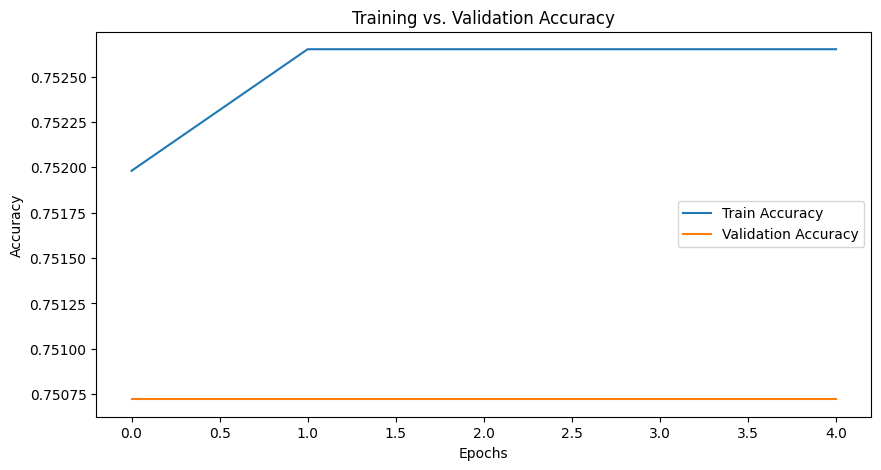

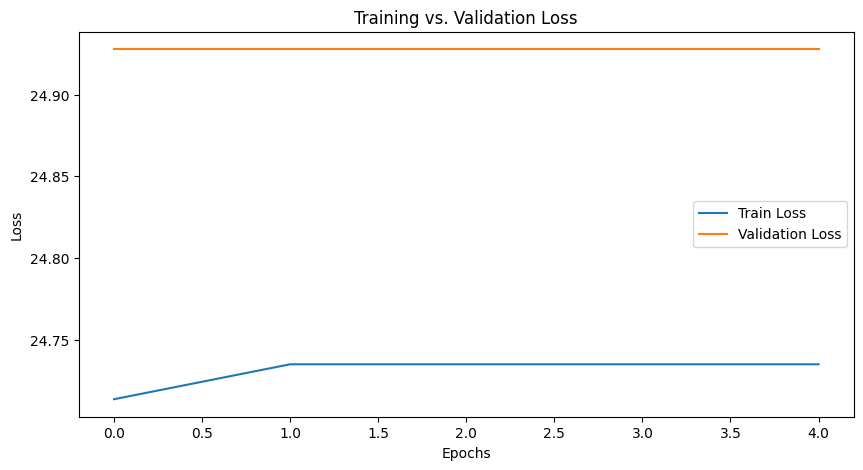

[INFO] Training completed. Best model loaded.


In [14]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs. Validation Accuracy")
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()

print("[INFO] Training completed. Best model loaded.")

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
import cv2

# Dataset class
class DeepfakeDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spatial_frame_path = self.data.iloc[idx, 0]
        optical_flow_path = self.data.iloc[idx, 1]
        label = self.data.iloc[idx, 2]

        spatial_frame = Image.open(spatial_frame_path).convert("RGB")
        optical_flow = np.load(optical_flow_path)  # Assuming optical flow is saved as numpy arrays

        if self.transform:
            spatial_frame = self.transform(spatial_frame)
            optical_flow = torch.tensor(optical_flow, dtype=torch.float32).permute(2, 0, 1)  # Convert to CxHxW format

        return {"spatial_frame": spatial_frame, "optical_flow": optical_flow, "label": torch.tensor(label, dtype=torch.long)}

# Model architecture
class DeepfakeDetector(nn.Module):
    def __init__(self):
        super(DeepfakeDetector, self).__init__()
        # Spatial feature extraction
        self.spatial_features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(8, 8, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(4)
        )
        
        # Temporal feature extraction
        self.temporal_features = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 8 * 8 * 2, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 1), nn.Sigmoid()
        )

    def forward(self, spatial_frame, optical_flow):
        spatial_features = self.spatial_features(spatial_frame)
        temporal_features = self.temporal_features(optical_flow)
        combined_features = torch.cat((spatial_features.flatten(start_dim=1), temporal_features.flatten(start_dim=1)), dim=1)
        output = self.fc(combined_features)
        return output

# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset and DataLoader
csv_file = "angry_dataset_real_fake_filtered.csv"
dataset = DeepfakeDataset(csv_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, loss, and optimizer
model = DeepfakeDetector().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        spatial_frame = batch["spatial_frame"].to(device)
        optical_flow = batch["optical_flow"].to(device)
        labels = batch["label"].to(device).float()
        
        optimizer.zero_grad()
        outputs = model(spatial_frame, optical_flow).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")


ValueError: Cannot load file containing pickled data when allow_pickle=False